In [1]:
# import packages
from scipy.stats import norm, t
import scipy
import numpy as np
import pandas as pd
import sys 
import os
sys.path.append(os.path.abspath("/Users/pudong/Desktop"))
import risklib
from datetime import datetime
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Question 1

In [ ]:
# Closed form greeks for GBSM

In [2]:
current_date = datetime(2022, 3, 13)
expire_date = datetime(2022, 4, 15)
T = (expire_date - current_date).days / 365

S = 151.03
X = 165
sigma = 0.2

r = 0.0425
coupon = 0.0053
b = r - coupon

In [3]:
def calculate_d1(S, X, T, sigma, b):
    return (np.log(S / X) + (b + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))

def calculate_d2(d1, T, sigma):
    return d1 - sigma * np.sqrt(T)

In [4]:
def gbsm_delta(option_type, S, X, T, sigma, r, b):
    is_call = 1 if option_type == "Call" else -1
    d1 = calculate_d1(S, X, T, sigma, b)
    delta = norm.cdf(d1 * is_call, 0, 1) * is_call
    return delta

def gbsm_gamma(option_type, S, X, T, sigma, r, b):
    d1 = calculate_d1(S, X, T, sigma, b)
    d2 = calculate_d2(d1, T, sigma)
    gamma = norm.pdf(d1, 0, 1) / (S * sigma * np.sqrt(T))
    return gamma

def gbsm_vega(option_type, S, X, T, sigma, r, b):
    d1 = calculate_d1(S, X, T, sigma, b)
    d2 = calculate_d2(d1, T, sigma)
    vega = S * norm.pdf(d1, 0, 1) * np.sqrt(T)
    return vega

def gbsm_theta(option_type, S, X, T, sigma, r, b):
    is_call = 1 if option_type == "Call" else -1
    d1 = calculate_d1(S, X, T, sigma, b)
    d2 = calculate_d2(d1, T, sigma)
    theta = -S * np.exp((b - r) * T) * norm.pdf(d1, 0, 1) * sigma / (2 * np.sqrt(T)) \
          -(b - r) * S * np.exp((b - r) * T) * norm.cdf(d1 * is_call, 0, 1) * is_call \
          -r * X * np.exp(-r * T) * norm.cdf(d2 * is_call, 0, 1) * is_call
    return theta

def gbsm_rho(option_type, S, X, T, sigma, r, b):
    is_call = 1 if option_type == "Call" else -1
    d1 = calculate_d1(S, X, T, sigma, b)
    d2 = calculate_d2(d1, T, sigma)
    rho = X * T * np.exp(-r * T) * norm.cdf(d2 * is_call, 0, 1) * is_call
    return rho

def gbsm_carry_rho(option_type, S, X, T, sigma, r, b):
    is_call = 1 if option_type == "Call" else -1
    d1 = calculate_d1(S, X, T, sigma, b)
    d2 = calculate_d2(d1, T, sigma)
    carry_rho = S * T * np.exp((b - r) * T) * norm.cdf(d1 * is_call, 0, 1) * is_call
    return carry_rho

In [ ]:
# Finite difference derivative calculation and comparison.

In [5]:
import inspect

# calculate first order derivative
def first_order_der(func, x, delta):
    return (func(x + delta) - func(x - delta)) / (2 * delta)

# calculate second order derivative
def second_order_der(func, x, delta):
    return (func(x + delta) + func(x - delta) - 2 * func(x)) / delta ** 2

def cal_partial_derivative(func, order, arg_name, delta=1e-3):
    # initialize for argument names and order
    arg_names = list(inspect.signature(func).parameters.keys())
    derivative_fs = {1: first_order_der, 2: second_order_der}

    def partial_derivative(*args, **kwargs):
        # parse argument names and order
        args_dict = dict(list(zip(arg_names, args)) + list(kwargs.items()))
        arg_val = args_dict.pop(arg_name)

        def partial_f(x):
            p_kwargs = {arg_name:x, **args_dict}
            return func(**p_kwargs)
        return derivative_fs[order](partial_f, arg_val, delta)
    return partial_derivative

In [7]:
def gbsm(option_type, S, X, T, sigma, r, b):
    d1 = (np.log(S / X) + (b + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    is_call = 1 if option_type == "Call" else -1

    res = is_call * (S * np.e ** ((b - r) * T) * \
                   scipy.stats.norm(0, 1).cdf(is_call * d1) \
                   - X * np.e ** (-r * T) * \
                   scipy.stats.norm(0, 1).cdf(is_call * d2))
    
    return res

In [8]:
# delta
delta_call = gbsm_delta("Call", S, X, T, sigma, r, b)
delta_put = gbsm_delta("Put", S, X, T, sigma, r, b)
gbsm_delta_num = cal_partial_derivative(gbsm, 1, 'S')
delta_call_num = gbsm_delta_num("Call", S, X, T, sigma, r, b)
delta_put_num = gbsm_delta_num("Put", S, X, T, sigma, r, b)
print(delta_call, delta_put)
print(delta_call_num, delta_put_num)

0.08301107089626869 -0.9169889291037313
0.08297130374668171 -0.9165496329472944


In [9]:
# gamma
gamma_call = gbsm_gamma("Call", S, X, T, sigma, r, b)
gamma_put = gbsm_gamma("Put", S, X, T, sigma, r, b)
gbsm_gamma_num = cal_partial_derivative(gbsm, 2, 'S')
gamma_call_num = gbsm_gamma_num("Call", S, X, T, sigma, r, b)
gamma_put_num = gbsm_gamma_num("Put", S, X, T, sigma, r, b)
print(gamma_call, gamma_put)
print(gamma_call_num, gamma_put_num)

0.016830979206204362 0.016830979206204362
0.016822911064195978 0.016822951920403284


In [10]:
# vega
vega_call = gbsm_vega("Call", S, X, T, sigma, r, b)
vega_put = gbsm_vega("Put", S, X, T, sigma, r, b)
gbsm_vega_num = cal_partial_derivative(gbsm, 1, 'sigma')
vega_call_num = gbsm_vega_num("Call", S, X, T, sigma, r, b)
vega_put_num = gbsm_vega_num("Put", S, X, T, sigma, r, b)
print(vega_call, vega_put)
print(vega_call_num, vega_put_num)

6.942036604441163 6.942036604441163
6.938653056250743 6.93865305626673


In [11]:
# theta
theta_call = gbsm_theta("Call", S, X, T, sigma, r, b)
theta_put = gbsm_theta("Put", S, X, T, sigma, r, b)
gbsm_theta_num = cal_partial_derivative(gbsm, 1, 'T')
theta_call_num = -gbsm_theta_num("Call", S, X, T, sigma, r, b)
theta_put_num = -gbsm_theta_num("Put", S, X, T, sigma, r, b)
print(theta_call, theta_put)
print(theta_call_num, theta_put_num)

-8.126522359668838 -1.9409914783019566
-8.126308803761084 -1.9407779203106656


In [12]:
# rho
rho_call = gbsm_rho("Call", S, X, T, sigma, r, b)
rho_put = gbsm_rho("Put", S, X, T, sigma, r, b)
gbsm_rho_num = cal_partial_derivative(gbsm, 1, 'r')
rho_call_num = gbsm_rho_num("Call", S, X, T, sigma, r, b)
rho_put_num = gbsm_rho_num("Put", S, X, T, sigma, r, b)
print(rho_call, rho_put)
print(rho_call_num, rho_put_num)

1.1025939156368187 -13.758003122735788
-0.030359909416688424 -1.2427313238703164


In [13]:
# carry rho
carry_rho_call = gbsm_carry_rho("Call", S, X, T, sigma, r, b)
carry_rho_put = gbsm_carry_rho("Put", S, X, T, sigma, r, b)
gbsm_carry_rho_num = cal_partial_derivative(gbsm, 1, 'b')
carry_rho_call_num = gbsm_carry_rho_num("Call", S, X, T, sigma, r, b)
carry_rho_put_num = gbsm_carry_rho_num("Put", S, X, T, sigma, r, b)
print(carry_rho_call, carry_rho_put)
print(carry_rho_call_num, carry_rho_put_num)

1.132953825011723 -12.515271800549371
1.1329550097096686 -12.515270634423814


In [ ]:
# Binomial tree valuation for American options with and without discrete dividends

In [14]:
def n_nodes(N):
    return (N + 2) * (N + 1) // 2

def node_index(i, j):
    return n_nodes(j - 1) + i

def binomial_tree_no_div(option_type, S0, X, T, sigma, r, N):
    is_call = 1 if option_type == "Call" else -1
    dt = T / N
    disc = np.exp(-r * dt)
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    
    C = np.empty(n_nodes(N), dtype=float)
            
    for i in np.arange(N, -1, -1):
        for j in range(i, -1, -1):
            S = S0 * u ** j * d ** (i - j)
            index = node_index(j, i)
            C[index] = max(0, (S - X) * is_call)
            if i < N:
                val = disc * (p * C[node_index(j + 1, i + 1)] + (1 - p) * C[node_index(j, i + 1)])
                C[index] = max(C[index], val)
                
    return C[0]

def binomial_tree(option_type, S0, X, T, div_time, div, sigma, r, N):
    if div_date is None or div is None:
        return binomial_tree_no_div(option_type, S0, X, T, sigma, r, N)
  
    is_call = 1 if option_type == "Call" else -1
    dt = T / N
    disc = np.exp(-r * dt)
    
    #calculate u, d, and p
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
 
    new_T = T - div_time * dt
    new_N = N - div_time

    C = np.empty(n_nodes(div_time), dtype=float)
    for i in range(div_time, -1, -1):
        for j in range(i, -1, -1):
            S = S0 * u ** j * d ** (i - j)
            val_exe = max(0, (S - X) * is_call)
            if i < div_time:
                val = disc * (p * C[node_index(j + 1, i + 1)] + (1 - p) * C[node_index(j, i + 1)])
            else:
                val = binomial_tree(option_type, S - div, X, new_T, None, None, sigma, r, new_N)
            C[node_index(j, i)] = max(val_exe, val)
    
    return C[0]

In [ ]:
# Calculate the value of the call and the put. Calculate the Greeks of each.

In [15]:
# Assume N is 200
N = 200
value_no_div_call = binomial_tree_no_div("Call", S, X, T, sigma, r, N)
value_no_div_put = binomial_tree_no_div("Put", S, X, T, sigma, r, N)
print("Binomial tree value without dividend for call: " + str(value_no_div_call))
print("Binomial tree value without dividend for put: " + str(value_no_div_put))

Binomial tree value without dividend for call: 0.3420415058233237
Binomial tree value without dividend for put: 14.02022659787544


In [16]:
div_date = datetime(2022, 4, 11)
div = 0.88
div_time = int((div_date - current_date).days / (expire_date - current_date).days * N)

value_call = binomial_tree("Call", S, X, T, div_time, div, sigma, r, N)
value_put = binomial_tree("Put", S, X, T, div_time, div, sigma, r, N)
print("Binomial tree value with dividend for call: " + str(value_call))
print("Binomial tree value with dividend for put: " + str(value_put))

Binomial tree value with dividend for call: 0.2981599372927687
Binomial tree value with dividend for put: 14.55911431446306


In [17]:
# delta
cal_amr_delta_num = cal_partial_derivative(binomial_tree, 1, 'S0')
delta_call_amr = cal_amr_delta_num("Call", S, X, T, div_time, div, sigma, r, N)
delta_put_amr = cal_amr_delta_num("Put", S, X, T, div_time, div, sigma, r, N)
print(delta_call_amr, delta_put_amr)

0.0694035170404339 -0.9384266902472405


In [18]:
# gamma
cal_amr_gamma_num = cal_partial_derivative(binomial_tree, 2, 'S0', delta=1)
gamma_call_amr = cal_amr_gamma_num("Call", S, X, T, div_time, div, sigma, r, N)
gamma_put_amr = cal_amr_gamma_num("Put", S, X, T, div_time, div, sigma, r, N)
print(gamma_call_amr, gamma_put_amr)

0.0188730869562459 0.017693002005984226


In [19]:
# vega
cal_amr_vega_num = cal_partial_derivative(binomial_tree, 1, 'sigma')
vega_call_amr = cal_amr_vega_num("Call", S, X, T, div_time, div, sigma, r, N)
vega_put_amr = cal_amr_vega_num("Put", S, X, T, div_time, div, sigma, r, N)
print(vega_call_amr, vega_put_amr)

6.143196715376997 5.664125621646754


In [23]:
# theta
cal_amr_theta_num = cal_partial_derivative(binomial_tree, 1, 'T')
theta_call_amr = -cal_amr_theta_num("Call", S, X, T, div_time, div, sigma, r, N)
theta_put_amr = -cal_amr_theta_num("Put", S, X, T, div_time, div, sigma, r, N)
print(theta_call_amr, theta_put_amr)

-7.2765273123804315 -0.46564521876213405


In [24]:
# rho
cal_amr_rho_num = cal_partial_derivative(binomial_tree, 1, 'r')
rho_call_amr = cal_amr_rho_num("Call", S, X, T, div_time, div, sigma, r, N)
rho_put_amr = cal_amr_rho_num("Put", S, X, T, div_time, div, sigma, r, N)
print(rho_call_amr, rho_put_amr)

0.9426794754235357 -12.407586180172459


In [ ]:
# sensitivity of the put and call to a change in the dividend amount?

In [25]:
delta = 1e-3
call_value1 = binomial_tree("Call", S, X, T, div_time, div + delta, sigma, r, N)    
call_value2 = binomial_tree("Call", S, X, T, div_time, div - delta, sigma, r, N)    
call_sens_to_div_amount = (call_value1 - call_value2) / (2*delta)

put_value1 = binomial_tree("Put", S, X, T, div_time, div + delta, sigma, r, N)    
put_value2 = binomial_tree("Put", S, X, T, div_time, div - delta, sigma, r, N)    
put_sens_to_div_amount = (put_value1 - put_value2) / (2*delta)
print(f"Sensitivity to dividend amount: Call: {call_sens_to_div_amount:.3f}, Put: {put_sens_to_div_amount:.3f}")

Sensitivity to dividend amount: Call: -0.025, Put: 0.941


In [ ]:
# Question 2

In [ ]:
# Simulate through price changes

In [26]:
def implied_vol_american(option_type, S0, X, T, div_time, div, r, N, market_price, x0=0.5):
    def equation(sigma):
        return binomial_tree(option_type, S0, X, T, div_time, div, sigma, r, N) - market_price
    # Back solve the binomial tree valuation to get the implied volatility
    return scipy.optimize.fsolve(equation, x0=x0, xtol=0.00001)[0]

def calculate_sim_values(portfolios, sim_prices, days_ahead=0):
    sim_values = pd.DataFrame(index=portfolios.index, 
                              columns=list(range(sim_prices.shape[0])))
    sim_prices = np.array(sim_prices)
    for i in portfolios.index:
        if portfolios["Type"][i] == "Stock":
            # For stock, the single value is its price
            single_values = sim_prices
        else:
            # For option, calculate values with gbsm method
            option_type = portfolios["OptionType"][i]
            X = portfolios["Strike"][i]
            T = ((portfolios["ExpirationDate"][i] - current_date).days - days_ahead) / 365
            sigma = portfolios["ImpliedVol"][i]
            div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
            div = 1
            option_values = []
            for S in sim_prices:
                option_values.append(binomial_tree(option_type, S, X, T, div_time, div, sigma, r, N))
            single_values = np.array(option_values)
    
        # Calculate the total values based on holding
        sim_values.loc[i, :] = portfolios["Holding"][i] * single_values
  
    # Combine the values for same portfolios
    sim_values['Portfolio'] = portfolios['Portfolio']
    return sim_values.groupby('Portfolio').sum()

In [27]:
portfolios = pd.read_csv('problem2.csv', parse_dates=['ExpirationDate'])
portfolios['CurrentValue'] = portfolios['CurrentPrice'] * portfolios['Holding']

S = 151.03
N = 25
current_date = datetime(2023, 3, 3)
div_date = datetime(2023, 3, 15)
r = 0.0425
div = 1

# Calculate the implied volatility for all portfolios
implied_vols = []
for i in range(len(portfolios.index)):
    if portfolios["Type"][i] == "Stock":
        implied_vols.append(None)
    else:
        option_type = portfolios["OptionType"][i]
        X = portfolios["Strike"][i]
        T = (portfolios["ExpirationDate"][i] - current_date).days / 365
        div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
        market_price = portfolios["CurrentPrice"][i]
        sigma = implied_vol_american(option_type, S, X, T, div_time, div, r, N, market_price)
        implied_vols.append(sigma)

# Store the implied volatility in portfolios
portfolios["ImpliedVol"] = implied_vols

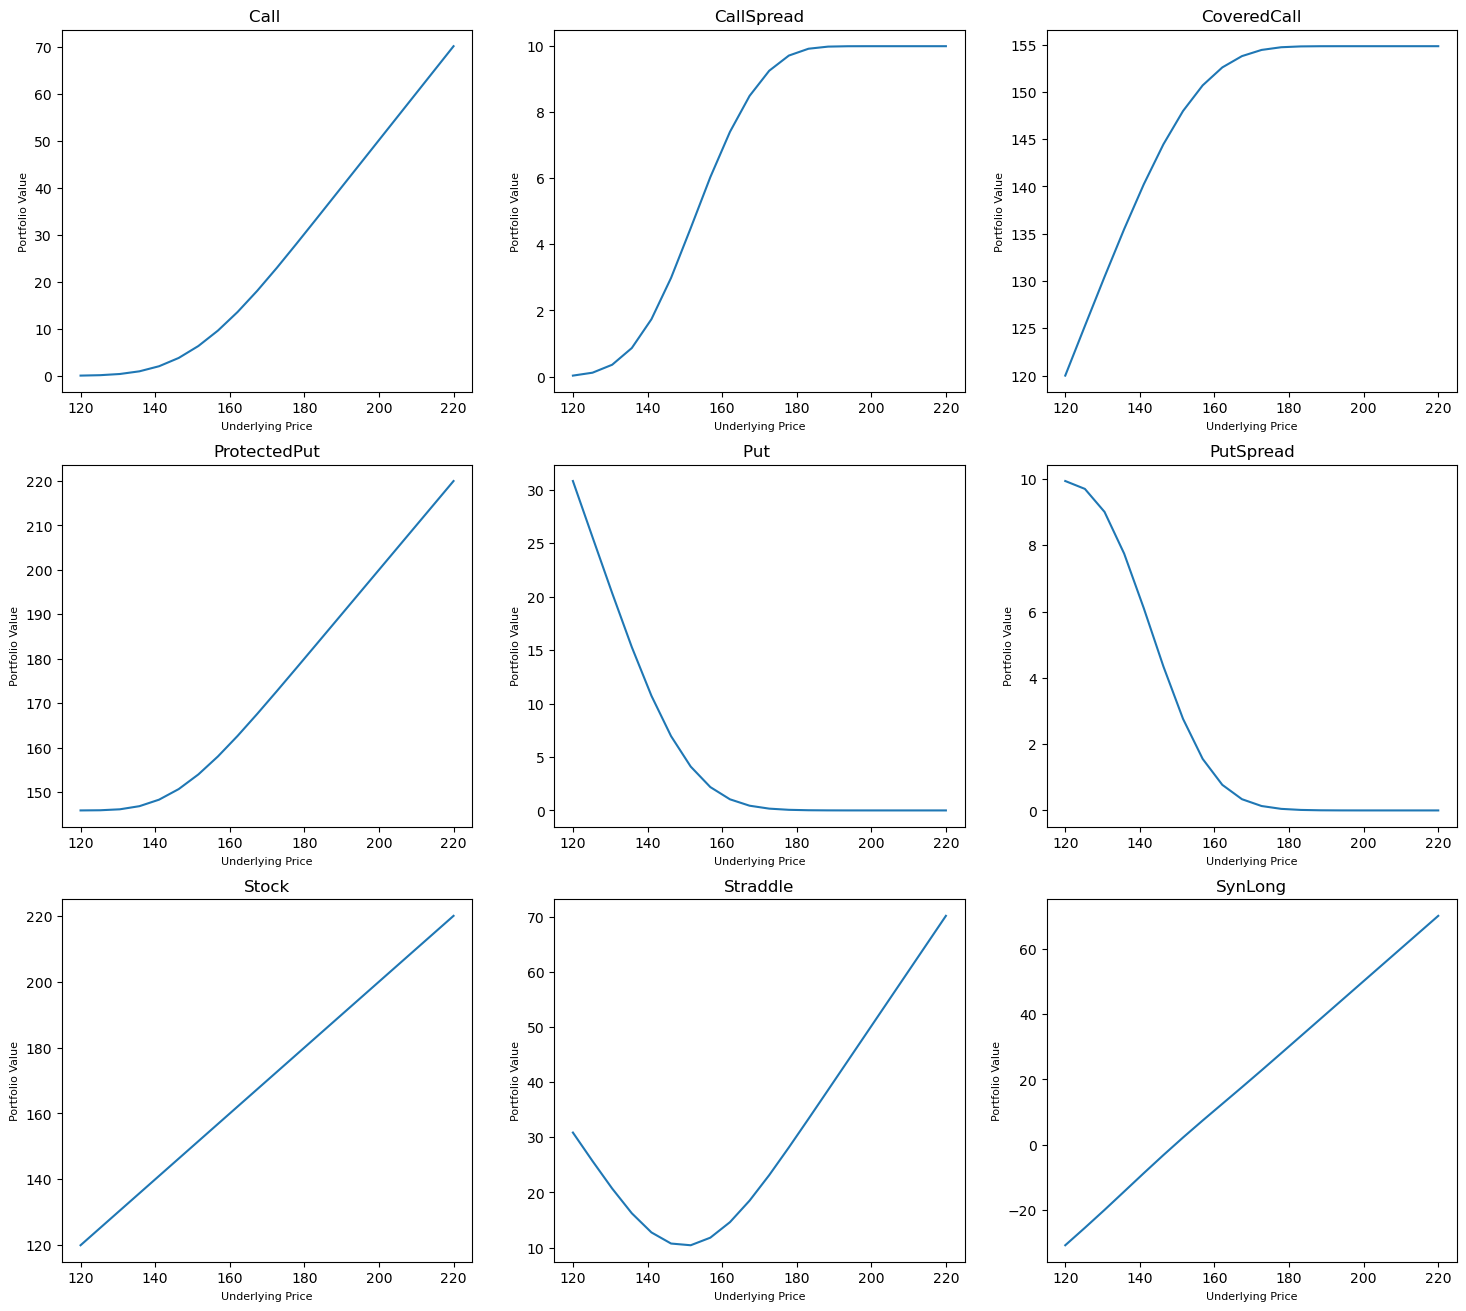

In [28]:
# Simulate the price in 120-220 range
sim_prices = np.linspace(120, 220, 20)

# Calculate the stock and option values
sim_values = calculate_sim_values(portfolios, sim_prices, 10)

# Plot the values for each portfolio
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
idx = 0
for portfolio, dataframe in sim_values.groupby('Portfolio'):
    i, j = idx // 3, idx % 3
    ax = axes[i][j]
    ax.plot(sim_prices, dataframe.iloc[0, :].values)
    ax.set_title(portfolio)
    ax.set_xlabel('Underlying Price', fontsize=8)
    ax.set_ylabel('Portfolio Value', fontsize=8)
    idx += 1

In [ ]:
# Fit Normal and calculate Mean, VaR and ES.

In [29]:
S = 151.03
N = 25
current_date = datetime(2023, 3, 3)
div_date = datetime(2023, 3, 15)
r = 0.0425
div = 1

daily_prices = pd.read_csv("DailyPrices.csv")
# Assume log return as last week
log_returns = np.log(daily_prices['AAPL']/daily_prices['AAPL'].shift(1)).dropna()
demeaned_returns = log_returns - np.mean(log_returns)

# Simulate the prices based on returns with normal distribution
std = demeaned_returns.std()
np.random.seed(0)
sim_returns = scipy.stats.norm(0, std).rvs((10, 100))
sim_prices = 151.03 * (1 + sim_returns).prod(axis=0)

# Calculate the current values and sim values
portfolios["CurrentValue"] = portfolios["CurrentPrice"] * portfolios["Holding"]
curr_values = portfolios.groupby('Portfolio')['CurrentValue'].sum()
sim_values = calculate_sim_values(portfolios, sim_prices, 10)

# Calculate the value difference
sim_value_changes = (sim_values.T - curr_values).T

# Calculate the Mean, VaR and ES, and print the results
result = pd.DataFrame(index=sim_value_changes.index)
result['Mean'] = sim_value_changes.mean(axis=1)
result['VaR'] = sim_value_changes.apply(lambda x:risklib.calculate_var(x, 0), axis=1)
result['ES'] = sim_value_changes.apply(lambda x:risklib.calculate_es(x), axis=1)
result

,Mean,VaR,ES
Portfolio,,,
Call,-0.127644,6.199831,6.562053
CallSpread,-0.525824,4.029122,4.361915
CoveredCall,-1.731967,13.914309,18.791813
ProtectedPut,0.042517,7.650810,8.040817
Put,1.952323,4.355154,4.649564
PutSpread,0.818268,2.627620,2.853856
Stock,-1.509956,17.804164,22.788306
Straddle,1.824678,1.348182,1.385833
SynLong,-2.079967,19.074750,24.324425


In [ ]:
# Calculate VaR and ES using Delta-Normal.

In [30]:
S = 151.03
N = 25
current_date = datetime(2023, 3, 3)
div_date = datetime(2023, 3, 15)
r = 0.0425
div = 1

cal_amr_delta_num =  cal_partial_derivative(binomial_tree, 1, 'S0')

# Calculate the implied volatility for all portfolios
deltas = []
for i in range(len(portfolios.index)):
    if portfolios["Type"][i] == "Stock":
        deltas.append(1)
    else:
        option_type = portfolios["OptionType"][i]
        X = portfolios["Strike"][i]
        T = ((portfolios["ExpirationDate"][i] - current_date).days - 10) / 365
        div_time = int((div_date - current_date).days / (portfolios["ExpirationDate"][i] - current_date).days * N)
        delta = cal_amr_delta_num(option_type, S, X, T, div_time, div, sigma, r, N)
        deltas.append(delta)

# Store the deltas in portfolios
portfolios["deltas"] = deltas

alpha = 0.05
t = 10
result_dn = pd.DataFrame(index=sorted(portfolios['Portfolio'].unique()), columns=['Mean', 'VaR', 'ES'])
result_dn.index.name = 'Portfolio'
for pfl, df in portfolios.groupby('Portfolio'):
    gradient = S / df['CurrentValue'].sum() * (df['Holding'] * df['deltas']).sum()
    pfl_10d_std = abs(gradient) * std * np.sqrt(t)
    N = scipy.stats.norm(0, 1)
    present_value = df['CurrentValue'].sum() 
    result_dn.loc[pfl]['Mean'] = 0
    result_dn.loc[pfl]['VaR'] = -present_value * N.ppf(alpha) * pfl_10d_std
    result_dn.loc[pfl]['ES'] = present_value * pfl_10d_std * N.pdf(N.ppf(alpha)) / alpha

result_dn

,Mean,VaR,ES
Portfolio,,,
Call,0,9.514631,11.931731
CallSpread,0,5.260949,6.597442
CoveredCall,0,10.895474,13.663364
ProtectedPut,0,12.13468,15.217378
Put,0,8.183037,10.261858
PutSpread,0,4.91428,6.162705
Stock,0,17.61745,22.092993
Straddle,0,1.331594,1.669873
SynLong,0,17.697668,22.193589


In [ ]:
# Compare these results to last week’s results.

In [31]:
def calculate_sim_values_week6(portfolios, sim_prices, days_ahead=0):
    sim_values = pd.DataFrame(index=portfolios.index, 
                              columns=list(range(sim_prices.shape[0])))
    sim_prices = np.array(sim_prices)
    for i in portfolios.index: 
        if portfolios["Type"][i] == "Stock":
            # For stock, the single value is its price
            single_values = sim_prices
        else:
            # For option, calculate values with gbsm method
            option_type = portfolios["OptionType"][i]
            S = sim_prices
            X = portfolios["Strike"][i]
            T = ((portfolios["ExpirationDate"][i] - current_date).days - days_ahead) / 365
            sigma = portfolios["ImpliedVol"][i]
            option_values = gbsm(option_type, S, X, T, sigma, r, b)
            single_values = option_values
    
        # Calculate the total values based on holding
        sim_values.loc[i, :] = portfolios["Holding"][i] * single_values
  
    # Combine the values for same portfolios
    sim_values['Portfolio'] = portfolios['Portfolio']
    return sim_values.groupby('Portfolio').sum()

S = 151.03
N = 25
current_date = datetime(2023, 3, 3)
div_date = datetime(2023, 3, 15)
r = 0.0425
div = 1

daily_prices = pd.read_csv("DailyPrices.csv")
#log return calculation
log_returns = np.log(daily_prices['AAPL']/daily_prices['AAPL'].shift(1)).dropna()
demeaned_returns = log_returns - np.mean(log_returns)
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(demeaned_returns, order=(1,0,0)).fit()

n_forecast = 10
sim = 1000
phi = model.params[1]
beta = model.params[0]
sigma = model.resid.std()

# Generate the simulated returns
simulated_returns = np.zeros((n_forecast,sim))
np.random.seed(0)
for j in range(sim):
    simulated_returns[0,j]= beta + phi * demeaned_returns.iloc[-1] + sigma * norm.rvs()
    for i in range(n_forecast-1):
        simulated_returns[i+1,j] = beta + phi * simulated_returns[i,j] + sigma * norm.rvs()
        
price_series = pd.DataFrame(daily_prices['AAPL'].iloc[-1] * np.exp(simulated_returns.cumsum(axis=0)))
sim_prices = price_series.loc[9:].values[0]

# Calculate the current values and sim values
portfolios["CurrentValue"] = portfolios["CurrentPrice"] * portfolios["Holding"]
curr_values = portfolios.groupby('Portfolio')['CurrentValue'].sum()
sim_values = calculate_sim_values(portfolios, sim_prices, 10)

# Calculate the value difference
sim_value_changes = (sim_values.T - curr_values).T

# Calculate the Mean, VaR and ES, and print the results
result_week6 = pd.DataFrame(index=sim_value_changes.index)
result_week6['Mean'] = sim_value_changes.mean(axis=1)
result_week6['VaR'] = sim_value_changes.apply(lambda x:risklib.calculate_var(x, 0), axis=1)
result_week6['ES'] = sim_value_changes.apply(lambda x:risklib.calculate_es(x), axis=1)
print(result_week6)

                  Mean        VaR         ES
Portfolio                                   
Call          0.106618   6.033670   6.370830
CallSpread   -0.334076   3.874866   4.184882
CoveredCall  -0.956813  12.718575  16.242387
ProtectedPut  0.370352   7.496637   7.845839
Put           1.243079   4.345846   4.590085
PutSpread     0.536272   2.619961   2.807518
Stock        -0.612572  16.550084  20.183831
Straddle      1.349697   1.372482   1.391239
SynLong      -1.136461  17.709756  21.576560


Text(0.5, 1.0, 'ES Comparison')

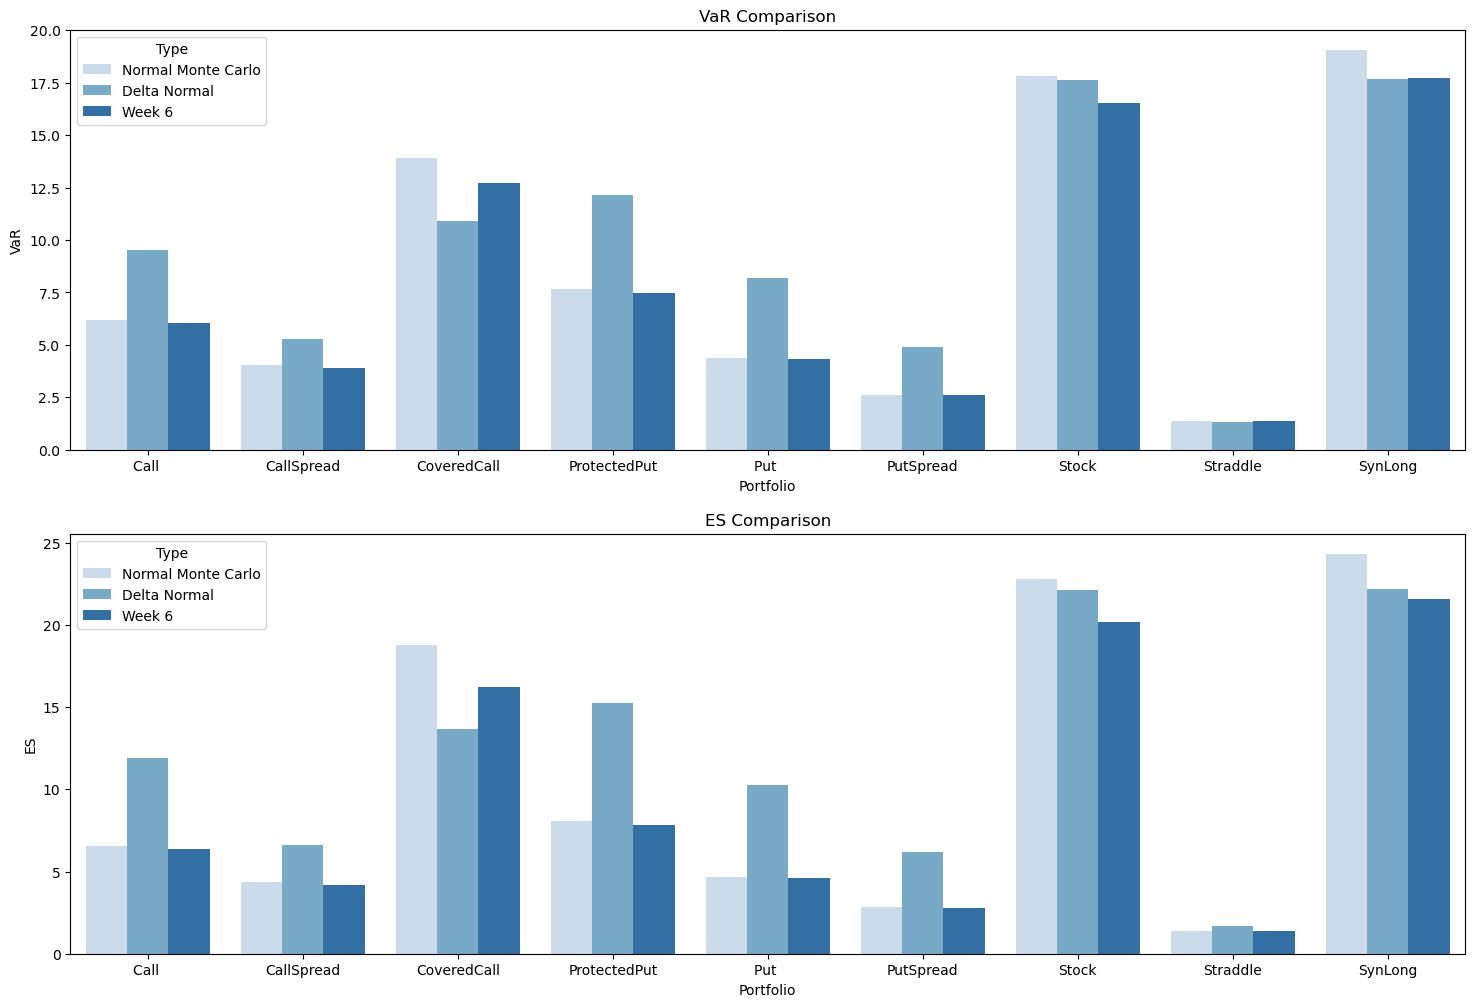

In [32]:
result_dfs = []
for category, result_df in zip(['Normal Monte Carlo', 'Delta Normal', 'Week 6'], [result, result_dn, result_week6]):
    new_result_df = result_df.reset_index()
    new_result_df['Type'] = category
    result_dfs.append(new_result_df)
result_dfs = pd.concat(result_dfs, axis=0)

fig, axes = plt.subplots(2, 1, figsize=(18, 12))
ax = sns.barplot(x='Portfolio', y='VaR', hue='Type', palette='Blues', data=result_dfs, ax=axes[0])
ax.set_title('VaR Comparison')

ax = sns.barplot(x='Portfolio', y='ES', hue='Type', palette='Blues', data=result_dfs, ax=axes[1])
ax.set_title('ES Comparison')

In [ ]:
# Question 3

In [33]:
# data preparation
ff = pd.read_csv('F-F_Research_Data_Factors_daily.csv', parse_dates=['Date']).set_index('Date')
mom = pd.read_csv('F-F_Momentum_Factor_daily.csv', parse_dates=['Date']).set_index('Date')
# transfer percentage to value
data = ff.join(mom, how='right') / 100

all_returns = pd.read_csv('DailyReturn.csv', parse_dates=['Date']).set_index('Date')
stocks = ['AAPL', 'META', 'UNH', 'MA',  
          'MSFT' ,'NVDA', 'HD', 'PFE',  
          'AMZN' ,'BRK-B', 'PG', 'XOM',  
          'TSLA' ,'JPM' ,'V', 'DIS',  
          'GOOGL', 'JNJ', 'BAC', 'CSCO']
factors = ['Mkt-RF', 'SMB', 'HML', 'RF']
dataset = all_returns[stocks].join(data) 
dataset = dataset.drop(['2023-02-01','2023-02-02','2023-02-03','2023-02-06','2023-02-07','2023-02-08','2023-02-09'], axis = 0)
dataset

,AAPL,META,UNH,MA,MSFT,NVDA,HD,PFE,AMZN,BRK-B,...,DIS,GOOGL,JNJ,BAC,CSCO,Mkt-RF,SMB,HML,RF,Mom
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-14,0.001423,-0.008426,-0.007801,0.011872,-0.000136,0.013278,0.003626,-0.019299,0.012222,-0.015228,...,0.009233,0.009260,-0.012581,-0.010434,-0.013358,-0.0035,0.0021,-0.0059,0.00000,-0.0007
2022-02-15,0.023152,0.015158,0.008073,0.019724,0.018542,0.091812,0.004836,-0.000201,0.008658,0.006109,...,0.025655,0.007987,0.010326,0.007803,0.020496,0.0187,0.0133,-0.0142,0.00000,-0.0091
2022-02-16,-0.001389,-0.020181,0.003806,0.003643,-0.001167,0.000604,-0.008974,-0.002209,0.010159,-0.001739,...,0.010535,0.008268,-0.000598,-0.002302,-0.000368,-0.0002,-0.0009,0.0031,0.00000,0.0064
2022-02-17,-0.021269,-0.040778,-0.020227,-0.024104,-0.029282,-0.075591,-0.006141,-0.015701,-0.021809,-0.006653,...,-0.021746,-0.037746,-0.006100,-0.033767,0.028018,-0.0228,-0.0028,0.0110,0.00000,0.0103
2022-02-18,-0.009356,-0.007462,-0.005379,-0.010035,-0.009631,-0.035296,-0.003075,-0.007566,-0.013262,0.003987,...,-0.010396,-0.016116,-0.010719,-0.002388,0.025820,-0.0087,-0.0009,0.0093,0.00000,0.0104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25,-0.004701,-0.011457,0.001831,0.006263,-0.005908,0.003011,-0.001353,0.008052,0.008929,0.001927,...,0.020000,-0.025384,0.007130,0.008678,0.003556,0.0000,-0.0004,0.0065,0.00017,0.0014
2023-01-26,0.014803,0.040989,-0.000041,-0.013468,0.030714,0.024789,-0.010874,-0.009180,0.020992,-0.003046,...,0.014613,0.024155,-0.003658,0.013479,0.007503,0.0108,-0.0058,0.0001,0.00017,-0.0123
2023-01-27,0.013684,0.030143,-0.013056,-0.008509,0.000645,0.028431,0.009178,-0.010395,0.030437,-0.005724,...,-0.001458,0.018971,-0.003908,0.003113,0.003517,0.0036,0.0062,-0.0116,0.00017,-0.0246


In [34]:
# calculate arithmetic E(r) in past 10 years
avg_factor_rets = data.loc['20130131':'20230131'].mean(axis=0)
avg_daily_rets = pd.Series()
for stock in stocks:
    # calculate betas
    model = sm.OLS(dataset[stock] - dataset['RF'], sm.add_constant(dataset[factors]))
    results = model.fit()
    
    # assume alpha = 0
    avg_daily_rets[stock] = (results.params[factors] * avg_factor_rets[factors]).sum() \
                            + avg_factor_rets['RF'] 

In [35]:
# geometric annual returns: mean and covariance
geo_means = np.log(1 + avg_daily_rets) * 255  
geo_covariance = np.log(1 + all_returns[stocks]).cov() * 255
print(geo_means)

AAPL     0.091534
META     0.365112
UNH     -0.065856
MA       0.181951
MSFT     0.110277
NVDA     0.453933
HD       0.195534
PFE     -0.020016
AMZN     0.142390
BRK-B    0.116971
PG       0.107805
XOM      0.047767
TSLA    -0.113033
JPM      0.300605
V        0.185255
DIS      0.300518
GOOGL    0.144748
JNJ     -0.047669
BAC      0.264950
CSCO     0.194649
dtype: float64


In [ ]:
display(geo_covariance)

In [36]:
# arithmetic annual returns: mean and covariance
arith_means = np.exp(geo_means + np.diagonal(geo_covariance.values) / 2) - 1

nstocks = geo_covariance.shape[0]
arith_covariance = np.empty((nstocks, nstocks), dtype=float)
for i in range(nstocks):
    for j in range(i, nstocks):
        mu_i, mu_j = geo_means.iloc[i], geo_means.iloc[j]
        sigma2_i, sigma2_j = geo_covariance.iloc[i, i], geo_covariance.iloc[j, j]
        sigma_ij = geo_covariance.iloc[i, j]
        arith_covariance[i, j] = np.exp(mu_i + mu_j + (sigma2_i + sigma2_j) / 2) * (np.exp(sigma_ij) - 1)
        arith_covariance[j, i] = arith_covariance[i, j]
arith_covariance = pd.DataFrame(arith_covariance, columns=stocks, index=stocks)

print(arith_means)

AAPL     0.168126
META     0.767960
UNH     -0.034531
MA       0.258958
MSFT     0.190769
NVDA     0.928453
HD       0.277411
PFE      0.015748
AMZN     0.304627
BRK-B    0.152897
PG       0.141542
XOM      0.114874
TSLA     0.128736
JPM      0.408032
V        0.254922
DIS      0.448933
GOOGL    0.253676
JNJ     -0.031274
BAC      0.370995
CSCO     0.270013
dtype: float64


In [ ]:
display(arith_covariance)

In [37]:
# calculate the most efficient portfolio which has the highest Sharpe ratio 
def neg_sharpe_ratio(weights, mean, cov, r):
    returns = mean @ weights.T
    std = np.sqrt(weights @ cov @ weights.T)
    return -(returns - r) / std

args = (arith_means, arith_covariance, 0.0025)
bounds = [(0.0, 1) for _ in stocks]
x0 = np.array(nstocks*[1 / nstocks])
constraints = {'type':'eq', 'fun': lambda x: np.sum(x) - 1}
results = scipy.optimize.minimize(neg_sharpe_ratio, x0=x0, args=args, bounds=bounds, constraints=constraints)
opt_sharpe, opt_weights = -results.fun, pd.Series(results.x, index=stocks)
opt_weights = pd.DataFrame(opt_weights, columns=['weights(%)'])
opt_weights['weights(%)'] = round(opt_weights*100, 2)

print("The most efficient portfolio consists of: ")
display(opt_weights)
print("The Portfolio's Sharpe Ratio is: " + str(opt_sharpe))

The most efficient portfolio consists of: 


,weights(%)
AAPL,0.00
META,4.67
UNH,0.00
MA,0.00
MSFT,0.00
NVDA,0.41
HD,7.36
PFE,0.00
AMZN,0.00
BRK-B,0.00


The Portfolio's Sharpe Ratio is: 1.0440801177075165
